# Code demo for [CLOUD](https://arxiv.org/abs/2506.17345)

This tutorial demonstrates the usage of **CLOUD**, a scalable and physics-informed foundation model for crystalline materials. CLOUD leverages a novel string-based representation, **SCOPE**, which encodes symmetry, Wyckoff positions, and composition without relying on atomic coordinates. Pretrained on 6.3 million crystals and fine-tuned on downstream tasks, CLOUD enables accurate property prediction and physics-consistent modeling. This tutorial walks through how to tokenize crystal structures, load the pretrained model, and fine-tune it for property prediction or physics-guided tasks like Cv via the **Debye** model.

To explore the full of our CLOUD foundation model for crystals, pleasen check out our repo: https://github.com/ChangwenXu98/CLOUD.

## Env setup

In [4]:
# Copy github repo
!git clone https://github.com/ChangwenXu98/CLOUD.git
%cd CLOUD

Cloning into 'CLOUD'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 95 (delta 38), reused 80 (delta 25), pack-reused 0 (from 0)
Receiving objects: 100% (95/95), 4.28 MiB | 6.29 MiB/s, done.
Resolving deltas: 100% (38/38), done.
/content/CLOUD


In [ ]:
# Install environment

# Install torch
!pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0

# Install huggingface transformers
!pip install transformers==4.44.2

# Install pymatgen for computationl materials science
!pip install pymatgen==2023.9.25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176

In [5]:
import yaml
import numpy as np
import pandas as pd
import os
import sys
import math
import functools
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.clip_grad import clip_grad_norm
from torch.optim import AdamW
from sklearn.model_selection import train_test_split

from transformers import BertModel, BertConfig, BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, TrainingArguments, Trainer

## Symmetry-Consistent Ordered Parameter Encoding (SCOPE)

SCOPE is a symmetry-consistent string representation for crystals that encodes symmetry (space group), equivalent sites (Wyckoff positions), and material compositions, enabling the model to learn structural and compositional information in a compact and generalizable format.

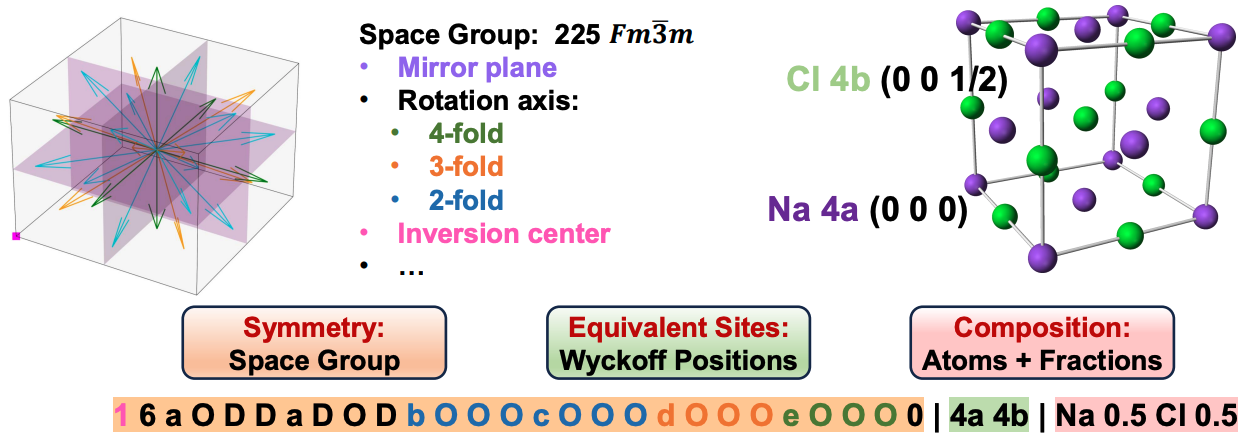

Tokenization is the process of converting the sequences into a sequence of discrete tokens that the model can understand. Each chemically or structurally meaningful unit—such as a symmetry symbol, Wyckoff position, element symbol, or stoichiometric number—is treated as a single token. These tokens are then mapped to integer IDs using a vocabulary and fed into the transformer model as input. We encourage you to check out the huggingface documentation for a better understanding of tokenization: https://huggingface.co/docs/transformers/en/main_classes/tokenizer

In [7]:
"""Load the tokenizer"""

tokenizer = BertTokenizer.from_pretrained("tokenizer_cloud_optimade", do_lower_case=False)

# Example
seq = "1 6 a O D D a D O D b O O O c O O O d O O O e O O O 0 | 4a 4b | Na 0.5 Cl 0.5"
tokens = tokenizer.tokenize(seq)
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['1', '6', 'a', 'O', 'D', 'D', 'a', 'D', 'O', 'D', 'b', 'O', 'O', 'O', 'c', 'O', 'O', 'O', 'd', 'O', 'O', 'O', 'e', 'O', 'O', 'O', '0', '|', '4a', '4b', '|', 'Na', '0.5', 'Cl', '0.5']
[7, 12, 40, 29, 19, 19, 40, 19, 29, 19, 41, 29, 29, 29, 42, 29, 29, 29, 43, 29, 29, 29, 44, 29, 29, 29, 6, 66, 105, 111, 66, 149, 513, 134, 513]


## Model

**Why Pretraining?**

Pretraining is a key step in building a foundation model like CLOUD. Instead of training from scratch on a small labeled dataset, the model is first trained on millions of unlabeled crystal structures using a self-supervised task (masked language modeling). This allows the model to learn general patterns of crystal symmetry, structure, and composition. The resulting model captures rich, transferable representations that can be fine-tuned for specific property prediction tasks with limited labeled data. This improves performance, generalization, and data efficiency—especially important in materials science where high-quality labels are expensive to obtain.

### Pre-train with Masked Language Modeling (MLM)

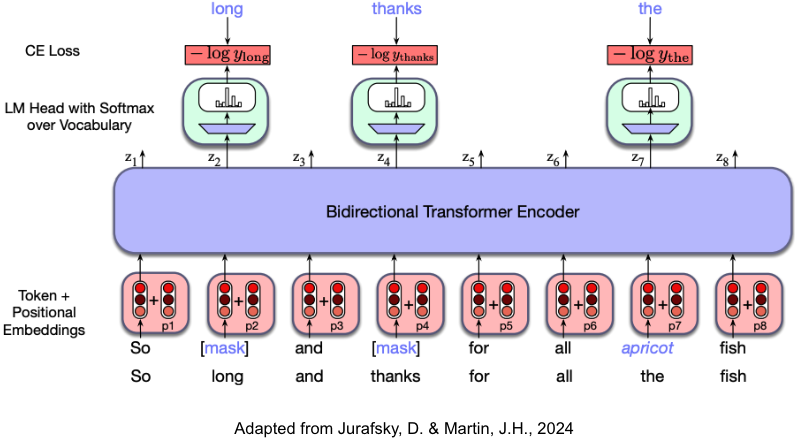

In [ ]:
"""Load the pretrain configs"""

# Use a small model and dataset for demo. Feel free to play with it.

yaml_str = """
file_path: 'example_data/pretrain_cloud_10k.csv'
gpu: 'cuda'
epochs: 3
lr_rate: 0.0001
scheduler_type: 'cosine'
weight_decay: 0.0
warmup_ratio: 0.05
save_strategy: 'epoch'
overwrite_output_dir: True
save_total_limit: 1
fp16: False
logging_strategy: 'epoch'
evaluation_strategy: 'epoch'
report_to: 'none'
sharded_ddp: False
save_path: "./runs/pretrain_demo"
load_checkpoint: False
ddp_backend: "nccl"
fsdp: "full_shard"

max_position_embeddings: 64
num_attention_heads: 4
num_hidden_layers: 6
hidden_dropout_prob: 0.1
attention_probs_dropout_prob: 0.1
mlm_probability: 0.15
dropout: 0.1

dataset:
  vocab_path: './tokenizer_cloud_optimade'
  blocksize: 64
  batch_size: 256
  dataloader_num_workers: 4
  seed: 0
"""

config = yaml.safe_load(yaml_str)

In [ ]:
"""Define the Pretrain dataset"""

class PretrainDataset(Dataset):
    def __init__(self, dataset, tokenizer, blocksize):
        self.tokenizer = tokenizer
        self.blocksize = blocksize
        self.dataset = dataset

    def __len__(self):
        self.len = len(self.dataset)
        return self.len

    def __getitem__(self, i):
        seq = self.dataset[i, 0]

        encoding = self.tokenizer(
            str(seq),
            add_special_tokens=True,
            max_length=self.blocksize,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
        )

In [ ]:
"""
Load data

For the pretrain dataset, use either the example dataset or the full one from
https://drive.google.com/drive/u/1/folders/1ci2LT8KeA3KLJqTAp39MP1nI3MasCJNg
"""

dataset = pd.read_csv(config["file_path"]).values
train_data, valid_data = train_test_split(dataset, test_size=0.2, random_state=config["dataset"]["seed"])

train_data = PretrainDataset(train_data, tokenizer, config["dataset"]["blocksize"])
valid_data = PretrainDataset(valid_data, tokenizer, config["dataset"]["blocksize"])

In [ ]:
"""Define the model and dataloader"""

bert_config = BertConfig(
    hidden_size=config['num_attention_heads'] * 64,
    intermediate_size=config['num_attention_heads'] * 64 * 4,
    max_position_embeddings=config['max_position_embeddings'],
    num_attention_heads=config['num_attention_heads'],
    num_hidden_layers=config['num_hidden_layers'],
    type_vocab_size=1,
    hidden_dropout_prob=config['hidden_dropout_prob'],
    attention_probs_dropout_prob=config['attention_probs_dropout_prob'],
)

model = BertForMaskedLM(config=bert_config)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=config['mlm_probability']
)

# Define the training arguments.
# Refer to https://huggingface.co/docs/transformers/en/main_classes/trainer#transformers.TrainingArguments for more information

training_args = TrainingArguments(
    output_dir=config['save_path'],
    overwrite_output_dir=config['overwrite_output_dir'],
    num_train_epochs=config['epochs'],
    per_device_train_batch_size=config["dataset"]["batch_size"],
    per_device_eval_batch_size=config["dataset"]["batch_size"],
    save_strategy=config['save_strategy'],
    save_total_limit=config['save_total_limit'],
    fp16=config['fp16'],
    logging_strategy=config['logging_strategy'],
    evaluation_strategy=config['evaluation_strategy'],
    learning_rate=config['lr_rate'],
    lr_scheduler_type=config['scheduler_type'],
    weight_decay=config['weight_decay'],
    warmup_ratio=config['warmup_ratio'],
    report_to=config['report_to'],
    dataloader_num_workers=config["dataset"]["dataloader_num_workers"],
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=valid_data,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
"""Run the trainer"""

trainer.train()
trainer.save_model(config["save_path"])

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch,Training Loss,Validation Loss
1,9.026900,8.005475
2,7.498500,7.067147
3,7.001100,6.883913


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.11/dist-packages/torch/util

### Fine-tune CLOUD for downstream tasks

With the pretrained model, we can finetune the model on downstream datasets for material property predictions.

In [ ]:
"""Load base configurations"""

# For the pretrained model checkpoint, use either the model you just trained or download the checkpoints from
# https://drive.google.com/drive/u/1/folders/1xH1LERoPgnKegaR3CWXTVFnQpLPpeUoC

yaml_str = """
gpu: 'cuda'
epochs: 10
optimizer: "adamw"
lr: 5e-5
min_lr: 1e-7
weight_decay: 0.0
warmup_epochs: 2
patience_epochs: 0
load_model: "./runs/pretrain_demo"
resume_from_checkpoint: False
log_every_n_steps: 50
fold_num: 1
LLRD: False
freeze_epoch: 0
test_MAE/MAD: True

model:
  max_position_embeddings: 64
  num_attention_heads: 4
  num_hidden_layers: 6
  hidden_dropout_prob: 0.1
  attention_probs_dropout_prob: 0.1
  dropout: 0.1
  num_layers: 1

dataset:
  dataset_name: 'matbench_log_gvrh'
  batch_size: 128
  num_workers: 2
  vocab_path: 'tokenizer_cloud_optimade'
  blocksize: 64
  map_path: './data/gen_map_large.json'
  seed: 0
  valid_size: 0.25
"""

config = yaml.safe_load(yaml_str)
print(config["model"]["num_hidden_layers"])  # example usage

6


In [ ]:
"""Model for downstream tasks"""

class Cloud(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        bert_config = BertConfig(
            hidden_size=config['num_attention_heads'] * 64,
            intermediate_size=config['num_attention_heads'] * 64 * 4,
            max_position_embeddings=config['max_position_embeddings'],
            num_attention_heads=config['num_attention_heads'],
            num_hidden_layers=config['num_hidden_layers'],
            type_vocab_size=1,
            hidden_dropout_prob=config['hidden_dropout_prob'],
            attention_probs_dropout_prob=config['attention_probs_dropout_prob'],
        )

        self.bert = BertModel(config=bert_config)

        layers = []
        layers.append(nn.Dropout(config["dropout"]))

        # Add the desired number of layers based on the hyperparameter
        for _ in range(config["num_layers"]):
            layers.append(nn.Linear(bert_config.hidden_size, bert_config.hidden_size))
            layers.append(nn.SiLU())

        # Add the final layer
        layers.append(nn.Linear(bert_config.hidden_size, 1))

        # Create the sequential model
        self.Regressor = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.last_hidden_state[:, 0, :]
        output = self.Regressor(logits)
        return output

In [ ]:
"""Define the DataLoader"""

class CloudDataset(Dataset):
    def __init__(self, df, tokenizer, blocksize, mu=0.0, std=1.0, train=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.blocksize = blocksize
        self.is_train = train

        if self.is_train:
            self.mu = np.mean(self.df.iloc[:, 1])
            self.std = np.std(self.df.iloc[:, 1])
        else:
            self.mu = mu
            self.std = std
        self.df.iloc[:, 1] = (self.df.iloc[:, 1] - self.mu) / self.std

    def __len__(self):
        return len(self.df)

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, index):
        scope = self.df.iloc[index, 0]
        target = self.df.iloc[index, 1]
        encoding = self.tokenizer(scope, max_length=self.blocksize, padding="max_length",
                                  truncation=True, return_tensors='pt')
        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            target=target
        )

# Example finetune data from dielectric_constant from MatBench
# Refer to the repo (https://github.com/ChangwenXu98/CLOUD) to learn how to load data for different benchmarks

def prepare_dataloaders(config, tokenizer, train_path, test_path):
    """
    Prepares train, validation, and test dataloaders from CSV files.

    Args:
        config (dict): Configuration dictionary.
        tokenizer: Tokenizer for text data.
        train_path (str): Path to the training CSV file (train + validation).
        test_path (str): Path to the test CSV file.

    Returns:
        train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader
    """
    # Read CSV files
    df_train_and_val = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    # Shuffle and split into train/validation
    num_data = df_train_and_val.shape[0]
    indices = list(df_train_and_val.index)
    random_state = np.random.RandomState(seed=config["dataset"]["seed"])
    random_state.shuffle(indices)
    split = int(np.floor(config["dataset"]["valid_size"] * num_data))
    val_idx = indices[:split]
    train_idx = indices[split:]
    df_valid = df_train_and_val.loc[val_idx, :].reset_index(drop=True)
    df_train = df_train_and_val.loc[train_idx, :].reset_index(drop=True)

    # Datasets
    train_dataset = CloudDataset(
        df_train, tokenizer, config["dataset"]["blocksize"]
    )
    valid_dataset = CloudDataset(
        df_valid, tokenizer, config["dataset"]["blocksize"],
        train_dataset.mu, train_dataset.std, train=False
    )
    test_dataset = CloudDataset(
        df_test, tokenizer, config["dataset"]["blocksize"],
        train_dataset.mu, train_dataset.std, train=False
    )

    # Dataloaders
    train_loader = DataLoader(
        train_dataset, config["dataset"]["batch_size"],
        shuffle=True, num_workers=config["dataset"]["num_workers"]
    )
    valid_loader = DataLoader(
        valid_dataset, config["dataset"]["batch_size"],
        shuffle=False, num_workers=config["dataset"]["num_workers"]
    )
    test_loader = DataLoader(
        test_dataset, config["dataset"]["batch_size"],
        shuffle=False, num_workers=config["dataset"]["num_workers"]
    )

    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = prepare_dataloaders(
  config, tokenizer,
  "example_data/finetune_dielectric_train_and_val.csv",
  "example_data/finetune_dielectric_test.csv"
)

In [ ]:
"""Finetune the model"""

def adjust_learning_rate(optimizer, epoch, config):
    """Decay the learning rate with half-cycle cosine after warmup"""
    max_lr = eval(config["lr"]) if isinstance(config["lr"], str) else config["lr"]
    min_lr = eval(config["min_lr"]) if isinstance(config["min_lr"], str) else config["min_lr"]
    if epoch < config['warmup_epochs']:
        lr = max_lr * epoch / config['warmup_epochs']
    elif epoch < config['warmup_epochs'] + config['patience_epochs']:
        lr = max_lr
    else:
        prev_epochs = config['warmup_epochs'] + config['patience_epochs']
        lr = min_lr + (max_lr - min_lr) * 0.5 * \
            (1. + math.cos(math.pi * (epoch - prev_epochs) / (config["epochs"] - prev_epochs)))
    for param_group in optimizer.param_groups:
        if "lr_scale" in param_group:
            param_group["lr"] = lr * param_group["lr_scale"]
        else:
            param_group["lr"] = lr


def train_model(config, train_loader, valid_loader, test_loader, train_dataset):

    # --- Device ---
    device = config["gpu"] if torch.cuda.is_available() and config["gpu"] != "cpu" else "cpu"
    print("Running on:", device)

    # --- Model ---
    model = Cloud(config["model"])
    if config["load_model"]:
        try:
            model.bert = model.bert.from_pretrained(config["load_model"])
            print("Loaded pre-trained model with success.")
        except Exception as e:
            print("Pre-trained weights not found. Training from scratch.", e)

    model = model.to(device)

    # --- Optimizer ---
    lr = eval(config["lr"]) if isinstance(config["lr"], str) else config["lr"]
    weight_decay = eval(config["weight_decay"]) if isinstance(config["weight_decay"], str) else config["weight_decay"]
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # --- Loss ---
    criterion = nn.L1Loss()

    # --- Training ---
    best_valid_loss = float('inf')
    mu = train_dataset.mu
    std = train_dataset.std

    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0
        for bn, batch in enumerate(tqdm(train_loader)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            target = batch["target"].to(device)

            adjust_learning_rate(optimizer, epoch + bn / len(train_loader), config)

            output = model(input_ids, attention_mask)
            loss = criterion(output.squeeze(), target.squeeze())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch}] Train Loss: {total_loss / len(train_loader):.4f}")

        # --- Validation ---
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                target = batch["target"].to(device)

                output = model(input_ids, attention_mask)
                output = output * std + mu
                target = target * std + mu
                loss = criterion(output.squeeze(), target.squeeze())
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        print(f"[Epoch {epoch}] Validation MAE: {valid_loss:.4f}")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "model_best.pth")

    # --- Test ---
    model.load_state_dict(torch.load("model_best.pth"))
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            target = batch["target"].to(device)

            output = model(input_ids, attention_mask)
            output = output * std + mu
            target = target * std + mu
            loss = criterion(output.squeeze(), target.squeeze())
            test_loss += loss.item()

    print(f"Test MAE: {test_loss / len(test_loader):.4f}")

In [ ]:
train_model(config, train_loader, valid_loader, test_loader, train_dataset)

Running on: cuda


Some weights of BertModel were not initialized from the model checkpoint at ./runs/pretrain_demo and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pre-trained model with success.


100%|██████████| 23/23 [00:03<00:00,  7.38it/s]

[Epoch 0] Train Loss: 0.3998


[Epoch 0] Validation MAE: 0.8049


100%|██████████| 23/23 [00:02<00:00,  9.20it/s]

[Epoch 1] Train Loss: 0.3554


[Epoch 1] Validation MAE: 0.7954


100%|██████████| 23/23 [00:02<00:00,  8.47it/s]

[Epoch 2] Train Loss: 0.3480


[Epoch 2] Validation MAE: 0.7920


100%|██████████| 23/23 [00:03<00:00,  7.44it/s]

[Epoch 3] Train Loss: 0.3452


[Epoch 3] Validation MAE: 0.7901


100%|██████████| 23/23 [00:02<00:00,  7.67it/s]

[Epoch 4] Train Loss: 0.3418


[Epoch 4] Validation MAE: 0.7884


100%|██████████| 23/23 [00:03<00:00,  6.27it/s]

[Epoch 5] Train Loss: 0.3583


[Epoch 5] Validation MAE: 0.7866


100%|██████████| 23/23 [00:02<00:00,  9.67it/s]

[Epoch 6] Train Loss: 0.3482


[Epoch 6] Validation MAE: 0.7856


100%|██████████| 23/23 [00:02<00:00,  8.63it/s]

[Epoch 7] Train Loss: 0.3411


[Epoch 7] Validation MAE: 0.7837


100%|██████████| 23/23 [00:02<00:00,  9.99it/s]

[Epoch 8] Train Loss: 0.3398


[Epoch 8] Validation MAE: 0.7836


100%|██████████| 23/23 [00:02<00:00,  9.90it/s]

[Epoch 9] Train Loss: 0.3367


[Epoch 9] Validation MAE: 0.7831
Test MAE: 0.5891


## CLOUD-DEBYE

While the base CLOUD model can directly predict heat capacity $C_v$ from crystal structure, it does so in a purely data-driven way, without incorporating physical laws. As illustrated in the top pathway of the figure, this limits the model to making predictions at specific temperatures seen during training and fails to capture the true temperature dependence of $C_v$—a violation of thermodynamic principles.

To address this limitation, we introduce CLOUD-DEBYE, a physics-informed extension of CLOUD. Instead of directly predicting $C_v$, the model first predicts the Debye temperature Θ, an intrinsic physical property of the material. This value is then passed into the Debye model, a thermodynamically consistent equation that governs the temperature dependence of lattice heat capacity:

$$C_v \approx 9Nk_B \left( \frac{T}{\Theta} \right)^3 \int_0^{x_D} \frac{x^4 e^x}{(e^x - 1)^2} \mathrm{d}x$$

As shown in the bottom pathway of the figure, this integration enforces correct asymptotic behavior (e.g., recovering the Dulong-Petit limit at high temperatures), ensures predictions are physically meaningful across all $T$, and provides strong generalization even beyond training conditions.

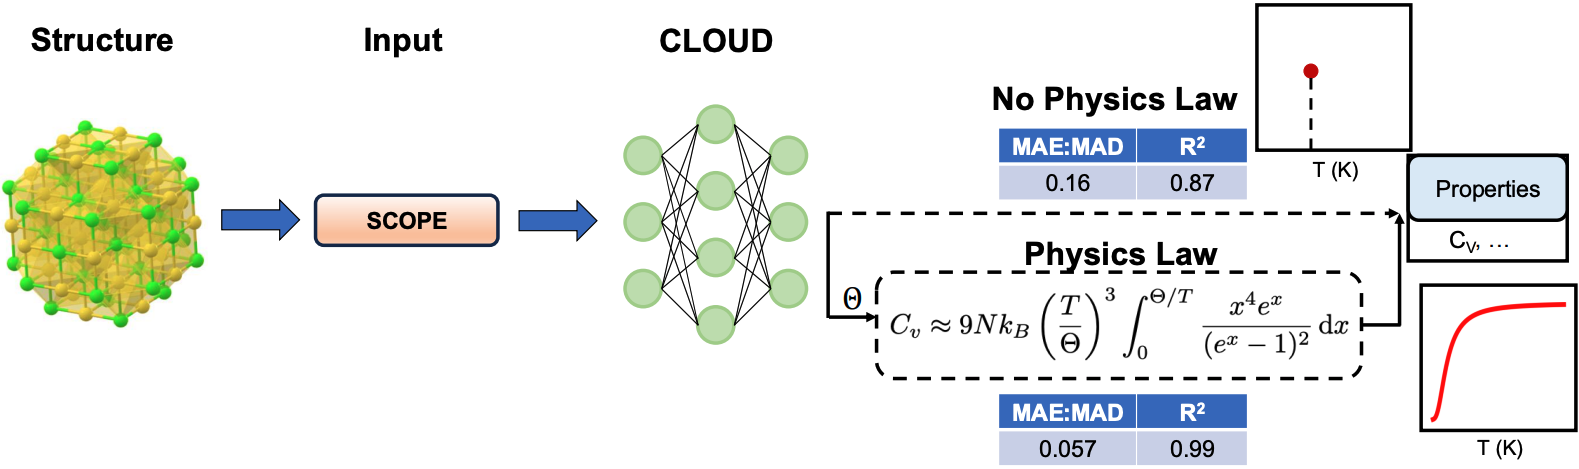

Let's first finetune the CLOUD model on Cv dataset

In [ ]:
"""Finetune on Cv without integration of physics"""

train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = prepare_dataloaders(
  config, tokenizer,
  "example_data/cloud_cv_train_and_val.csv",
  "example_data/cloud_cv_test.csv"
)

train_model(config, train_loader, valid_loader, test_loader, train_dataset)

Running on: cuda


Some weights of BertModel were not initialized from the model checkpoint at ./runs/pretrain_demo and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pre-trained model with success.


100%|██████████| 8/8 [00:01<00:00,  7.59it/s]

[Epoch 0] Train Loss: 0.8604


[Epoch 0] Validation MAE: 58.3162


100%|██████████| 8/8 [00:00<00:00,  8.60it/s]

[Epoch 1] Train Loss: 0.8167


[Epoch 1] Validation MAE: 59.4275


100%|██████████| 8/8 [00:00<00:00,  8.83it/s]

[Epoch 2] Train Loss: 0.8146


[Epoch 2] Validation MAE: 58.1046


100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

[Epoch 3] Train Loss: 0.8404


[Epoch 3] Validation MAE: 58.0279


100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

[Epoch 4] Train Loss: 0.8097


[Epoch 4] Validation MAE: 58.0567


100%|██████████| 8/8 [00:00<00:00,  8.84it/s]

[Epoch 5] Train Loss: 0.8568


[Epoch 5] Validation MAE: 57.8572


100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

[Epoch 6] Train Loss: 0.8156


[Epoch 6] Validation MAE: 58.0235


100%|██████████| 8/8 [00:01<00:00,  6.92it/s]

[Epoch 7] Train Loss: 0.7977


[Epoch 7] Validation MAE: 58.1377


100%|██████████| 8/8 [00:01<00:00,  7.23it/s]

[Epoch 8] Train Loss: 0.8533


[Epoch 8] Validation MAE: 58.0489


100%|██████████| 8/8 [00:01<00:00,  7.21it/s]

[Epoch 9] Train Loss: 0.8232


[Epoch 9] Validation MAE: 58.0242
Test MAE: 55.4940


Then let's implement CLOUD-DEBYE

In [ ]:
"""DataLoader for CLOUD-DEBYE"""

class CloudDebyeDataset(Dataset):
    def __init__(self, df, tokenizer, blocksize, train=True):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.blocksize = blocksize
        self.is_train = train

    def __len__(self):
        return len(self.df)

    @functools.lru_cache(maxsize=None)
    def __getitem__(self, index):
        scope = self.df.iloc[index, 0]
        target = self.df.iloc[index, 1]
        n_atoms = self.df.iloc[index, 2]
        encoding = self.tokenizer(scope, max_length=self.blocksize, padding="max_length",
                                  truncation=True, return_tensors='pt')
        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            target=target,
            n_atoms=n_atoms
        )


def prepare_cloud_debye_dataloaders(config, tokenizer, train_path, test_path):
    """
    Prepares train, validation, and test dataloaders from CSV files.

    Args:
        config (dict): Configuration dictionary.
        tokenizer: Tokenizer for text data.
        train_path (str): Path to the training CSV file (train + validation).
        test_path (str): Path to the test CSV file.

    Returns:
        train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader
    """
    # Read CSV files
    df_train_and_val = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)

    # Shuffle and split into train/validation
    num_data = df_train_and_val.shape[0]
    indices = list(df_train_and_val.index)
    random_state = np.random.RandomState(seed=config["dataset"]["seed"])
    random_state.shuffle(indices)
    split = int(np.floor(config["dataset"]["valid_size"] * num_data))
    val_idx = indices[:split]
    train_idx = indices[split:]
    df_valid = df_train_and_val.loc[val_idx, :].reset_index(drop=True)
    df_train = df_train_and_val.loc[train_idx, :].reset_index(drop=True)

    # Datasets
    train_dataset = CloudDebyeDataset(
        df_train, tokenizer, config["dataset"]["blocksize"]
    )
    valid_dataset = CloudDebyeDataset(
        df_valid, tokenizer, config["dataset"]["blocksize"], train=False
    )
    test_dataset = CloudDebyeDataset(
        df_test, tokenizer, config["dataset"]["blocksize"], train=False
    )

    # Dataloaders
    train_loader = DataLoader(
        train_dataset, config["dataset"]["batch_size"],
        shuffle=True, num_workers=config["dataset"]["num_workers"]
    )
    valid_loader = DataLoader(
        valid_dataset, config["dataset"]["batch_size"],
        shuffle=False, num_workers=config["dataset"]["num_workers"]
    )
    test_loader = DataLoader(
        test_dataset, config["dataset"]["batch_size"],
        shuffle=False, num_workers=config["dataset"]["num_workers"]
    )

    return train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader

train_dataset, valid_dataset, test_dataset, train_loader, valid_loader, test_loader = prepare_cloud_debye_dataloaders(
  config, tokenizer,
  "example_data/cloud_cv_train_and_val.csv",
  "example_data/cloud_cv_test.csv"
)

In order to enable end-to-end differentiability of the framework, we implement the Debye model using Gauss-Lengendre quadrature.

In [ ]:
"""CLOUD-DEBYE model"""

class Cloud_Debye(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        bert_config = BertConfig(
            hidden_size=config['num_attention_heads'] * 64,
            intermediate_size=config['num_attention_heads'] * 64 * 4,
            max_position_embeddings=config['max_position_embeddings'],
            num_attention_heads=config['num_attention_heads'],
            num_hidden_layers=config['num_hidden_layers'],
            type_vocab_size=1,
            hidden_dropout_prob=config['hidden_dropout_prob'],
            attention_probs_dropout_prob=config['attention_probs_dropout_prob'],
        )

        self.bert = BertModel(config=bert_config)

        layers = []
        layers.append(nn.Dropout(config["dropout"]))

        # Add the desired number of layers based on the hyperparameter
        for _ in range(config["num_layers"]):
            layers.append(nn.Linear(bert_config.hidden_size, bert_config.hidden_size))
            layers.append(nn.SiLU())

        # Add the final layer
        layers.append(nn.Linear(bert_config.hidden_size, 1))

        # Create the sequential model
        self.Regressor = nn.Sequential(*layers)


    def forward(self, input_ids, attention_mask, T=300, n_atoms=2, n=20, mu=1500.0, scale=1200.0, task="cv", return_theta=False):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.last_hidden_state[:, 0, :]
        theta = self.Regressor(logits).squeeze()
        theta = theta * scale + mu
        if return_theta:
            return theta
        if task == "cv":
            return self.Cv(theta=theta, T=T, n_atoms=n_atoms, n=n)
        elif task == "internal_energy":
            return self.U(theta=theta, T=T, n_atoms=n_atoms, n=n)

    def Cv(self, theta, T, n_atoms, n=20):
        """Compute heat capacity with PyTorch to allow backpropagation."""
        if T == 0:
            return torch.tensor(0.0, device=theta.device, dtype=theta.dtype)  # Avoid division by zero

        x_D = theta / T  # Upper limit of integration

        # Get Gauss-Legendre quadrature points and weights using PyTorch tensors
        x_np, w_np = np.polynomial.legendre.leggauss(n)

        x = torch.tensor(x_np, dtype=theta.dtype, device=theta.device).unsqueeze(0)  # Shape: [1, n]
        w = torch.tensor(w_np, dtype=theta.dtype, device=theta.device).unsqueeze(0)  # Shape: [1, n]

        x_D = x_D.unsqueeze(-1)  # Shape: [batch, 1]

        # Transform x from [-1,1] to [0,x_D]
        t = 0.5 * x_D * (x + 1)  # Rescale quadrature points
        dt_dx = 0.5 * x_D  # Jacobian of the transformation

        # Compute the function values at quadrature points using PyTorch
        f = (t**4 * torch.exp(t)) / (torch.exp(t) - 1)**2

        # Perform the quadrature integration
        integral = torch.sum(w * f, dim=-1) * dt_dx.squeeze(-1)

        # Compute C_v using PyTorch tensors
        C_v = 9 * (T / theta) ** 3 * integral * 8.314 * n_atoms

        return C_v

    def U(self, theta, T, n_atoms, n=20):
        """Compute heat capacity with PyTorch to allow backpropagation."""
        if T == 0:
            return torch.tensor(0.0, device=theta.device, dtype=theta.dtype)  # Avoid division by zero

        x_D = theta / T  # Upper limit of integration

        # Get Gauss-Legendre quadrature points and weights using PyTorch tensors
        x_np, w_np = np.polynomial.legendre.leggauss(n)

        x = torch.tensor(x_np, dtype=theta.dtype, device=theta.device).unsqueeze(0)  # Shape: [1, n]
        w = torch.tensor(w_np, dtype=theta.dtype, device=theta.device).unsqueeze(0)  # Shape: [1, n]

        x_D = x_D.unsqueeze(-1)  # Shape: [batch, 1]

        # Transform x from [-1,1] to [0,x_D]
        t = 0.5 * x_D * (x + 1)  # Rescale quadrature points
        dt_dx = 0.5 * x_D  # Jacobian of the transformation

        # Compute the function values at quadrature points using PyTorch
        f = (t**3) / (torch.exp(t) - 1)

        # Perform the quadrature integration
        integral = torch.sum(w * f, dim=-1) * dt_dx.squeeze(-1)

        # zero-point energy
        U_0 = 9/8 * 8.314 * n_atoms * theta

        # Compute C_v using PyTorch tensors
        U = 9 * (T / theta) ** 3 * integral * 8.314 * n_atoms * T + U_0

        return U

Finetune the model on Cv with CLOUD-DEBYE!

In [ ]:
def train_model_debye(config, train_loader, valid_loader, test_loader, train_dataset):

    # --- Device ---
    device = config["gpu"] if torch.cuda.is_available() and config["gpu"] != "cpu" else "cpu"
    print("Running on:", device)

    # --- Model ---
    model = Cloud_Debye(config["model"])
    if config["load_model"]:
        try:
            model.bert = model.bert.from_pretrained(config["load_model"])
            print("Loaded pre-trained model with success.")
        except Exception as e:
            print("Pre-trained weights not found. Training from scratch.", e)

    model = model.to(device)

    # --- Optimizer ---
    lr = eval(config["lr"]) if isinstance(config["lr"], str) else config["lr"]
    weight_decay = eval(config["weight_decay"]) if isinstance(config["weight_decay"], str) else config["weight_decay"]
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # --- Loss ---
    criterion = nn.L1Loss()

    # --- Training ---
    best_valid_loss = float('inf')

    for epoch in range(config["epochs"]):
        model.train()
        total_loss = 0
        for bn, batch in enumerate(tqdm(train_loader)):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            n_atoms = batch["n_atoms"].to(device)
            target = batch["target"].to(device)

            adjust_learning_rate(optimizer, epoch + bn / len(train_loader), config)

            output = model(input_ids, attention_mask, T=300, n_atoms=n_atoms, n=20, mu=config["mu"], scale=config["scale"], task=config["task"])
            loss = criterion(output.squeeze(), target.squeeze())

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=config['max_norm'])
            optimizer.step()

            total_loss += loss.item()

        print(f"[Epoch {epoch}] Train Loss: {total_loss / len(train_loader):.4f}")

        # --- Validation ---
        model.eval()
        valid_loss = 0
        with torch.no_grad():
            for batch in valid_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                n_atoms = batch["n_atoms"].to(device)
                target = batch["target"].to(device)

                output = model(input_ids, attention_mask, T=300, n_atoms=n_atoms, n=20, mu=config["mu"], scale=config["scale"], task=config["task"])
                loss = criterion(output.squeeze(), target.squeeze())
                valid_loss += loss.item()

        valid_loss /= len(valid_loader)
        print(f"[Epoch {epoch}] Validation MAE: {valid_loss:.4f}")

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), "model_debye_best.pth")

    # --- Test ---
    model.load_state_dict(torch.load("model_debye_best.pth"))
    model.eval()
    test_loss = 0
    num_data = 0
    test_mad = 0
    mu_train = np.mean(train_dataset.df.values[:, 1])
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            n_atoms = batch["n_atoms"].to(device)
            target = batch["target"].to(device)

            output = model(input_ids, attention_mask, T=300, n_atoms=n_atoms, n=20, mu=config["mu"], scale=config["scale"], task=config["task"])
            loss = criterion(output.squeeze(), target.squeeze())
            test_loss += loss.item() * output.shape[0]
            num_data += output.shape[0]
            test_mad += torch.sum(torch.abs(target - mu_train)).item()

    test_loss /= num_data
    print(f"Test MAE: {test_loss:.4f}")
    mae_mad_loss = test_loss * num_data / test_mad
    print(f"Test MAE/MAD: {mae_mad_loss:.4f}")

In [ ]:
"""Finetune with CLOUD-DEBYE"""

config["mu"] = 1500.0
config["scale"] = 1200.0
config["max_norm"] = 5.0
config["task"] = "cv"

train_model_debye(config, train_loader, valid_loader, test_loader, train_dataset)

Running on: cuda


Some weights of BertModel were not initialized from the model checkpoint at ./runs/pretrain_demo and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded pre-trained model with success.


100%|██████████| 8/8 [00:01<00:00,  4.37it/s]

[Epoch 0] Train Loss: 90.8213


[Epoch 0] Validation MAE: 62.8686


100%|██████████| 8/8 [00:01<00:00,  5.95it/s]

[Epoch 1] Train Loss: 35.3207


[Epoch 1] Validation MAE: 30.1559


100%|██████████| 8/8 [00:01<00:00,  6.29it/s]

[Epoch 2] Train Loss: 22.1645


[Epoch 2] Validation MAE: 22.3672


100%|██████████| 8/8 [00:01<00:00,  6.90it/s]

[Epoch 3] Train Loss: 26.6710


[Epoch 3] Validation MAE: 18.8804


100%|██████████| 8/8 [00:00<00:00,  8.14it/s]

[Epoch 4] Train Loss: 18.9299


[Epoch 4] Validation MAE: 20.8681


100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

[Epoch 5] Train Loss: 17.5649


[Epoch 5] Validation MAE: 17.2935


100%|██████████| 8/8 [00:01<00:00,  6.90it/s]

[Epoch 6] Train Loss: 18.4404


[Epoch 6] Validation MAE: 17.1374


100%|██████████| 8/8 [00:01<00:00,  6.61it/s]

[Epoch 7] Train Loss: 16.4301


[Epoch 7] Validation MAE: 17.4365


100%|██████████| 8/8 [00:00<00:00,  8.12it/s]

[Epoch 8] Train Loss: 17.7496


[Epoch 8] Validation MAE: 17.0861


100%|██████████| 8/8 [00:01<00:00,  7.77it/s]

[Epoch 9] Train Loss: 16.5535


[Epoch 9] Validation MAE: 17.0672
Test MAE: 16.7260
Test MAE/MAD: 0.3003


The model performance is improved even for just 300K $C_v$ predictions for which temperature dependency seems not so important. Such improvement could be attributed to the breakdown of learning complexity and the physical constraints due to the integration with Debye Model.

### Inference with CLOUD-DEBYE under different temperatures

After being trained on $C_v$ data at $T = 300K$, CLOUD-DEBYE can be extrapolated to predict $C_v$ at other temperatures.
We evaluate the model performance on different chemical systems: $Al_2O_3$ and $Li_2O$ are two oxides, $CaTiO_3$ belongs to perovskite, and $GaN$ is a III-V compound which is broadly used as semiconductors. We vary the temperature from 0 K to near the melting points of the compounds.

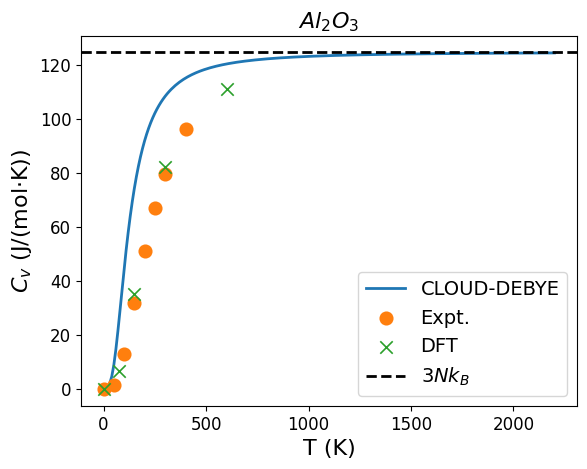

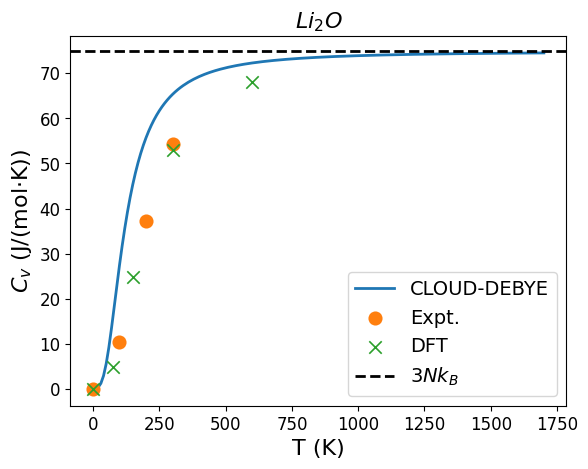

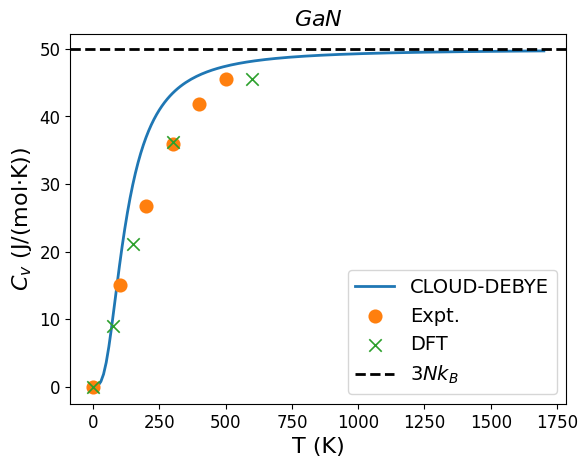

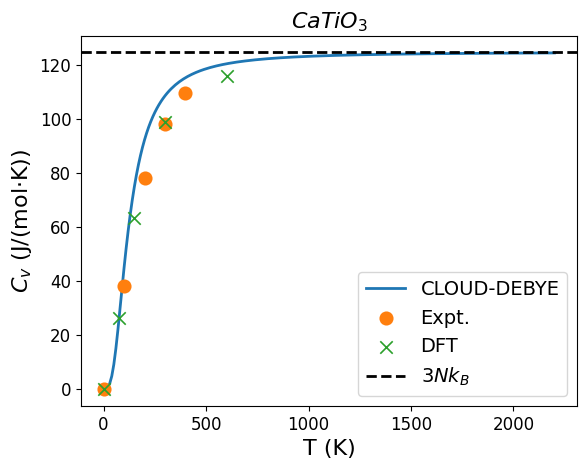

In [ ]:
# Inference

def predict(string_rep, model, n_atoms, T, tokenizer, device):
    encoding = tokenizer(
        string_rep,
        add_special_tokens=True,
        max_length=64,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    n_atoms = n_atoms.to(device)
    with torch.no_grad():
        output = model(input_ids, attention_mask, T=T, n_atoms=n_atoms, n=20, task="cv")
    return output.detach().cpu().numpy().flatten()[0]


def plot_cv(material_name, rep, n_atoms, temperature_range, T_ref, cv_ref, T_dft, cv_dft, asymptote, device):
    temperature = np.arange(*temperature_range)
    results = []
    for T in temperature:
        pred = predict(rep, model, torch.tensor(n_atoms), T, tokenizer, device)
        results.append(pred)

    tab20 = plt.get_cmap("tab20")
    plt.plot(temperature, results, linewidth=2, label="CLOUD-DEBYE", color=tab20(0))
    plt.scatter(T_ref, cv_ref, s=80, linewidth=1.2, label="Expt.", color=tab20(2), zorder=2)
    plt.scatter(T_dft, cv_dft, s=80, linewidth=1.2, marker='x', label='DFT', color=tab20(4), zorder=2)

    plt.axhline(y=asymptote, linestyle='--', color='black', linewidth=2.0, label="$3Nk_B$")
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel("T (K)", fontsize=16)
    plt.ylabel("$C_v$ (J/(mol·K))", fontsize=16)
    plt.legend(fontsize=14)
    plt.title(f"${material_name}$", fontsize=16)
    plt.show()
    plt.close()

device = torch.device(config["gpu"] if torch.cuda.is_available() else "cpu")

model = Cloud_Debye(config["model"])
checkpoints_path = "model_debye_best.pth"
state_dict = torch.load(checkpoints_path, weights_only=False)
model.load_state_dict(state_dict)
model.to(device=device)
model.eval()

# Al2O3
plot_cv(
    material_name="Al_2O_3",
    rep='1 3 a E C C n O O O e O O D 0 | 12c 18e | Al 0.4 O 0.6',
    n_atoms=5.0,
    temperature_range=(0, 2210, 10),
    T_ref=[0, 50, 100, 150, 200, 250, 300, 400],
    cv_ref=[0.000, 1.492, 12.84, 31.98, 51.14, 67.01, 79.41, 96.18],
    T_dft=[0, 75, 150, 300, 600],
    cv_dft=np.array([0.0, 13.20, 70.48, 163.99, 222.08]) / 2,
    asymptote=3 * 8.314 * 5, # 3NR
    device=device
)

# Li2O
plot_cv(
    material_name="Li_2O",
    rep='1 6 a O D D a D O D b O O O c O O O d O O O e O O O 0 | 8c 4a | Li 0.67 O 0.33',
    n_atoms=3.0,
    temperature_range=(0, 1710, 10),
    T_ref=[0, 100, 200, 300],
    cv_ref=[0.000, 10.447, 37.204, 54.379],
    T_dft=[0, 75, 150, 300, 600],
    cv_dft=[0.0, 4.85, 24.88, 52.92, 68.14],
    asymptote=3 * 8.314 * 3, # 3NR
    device=device
)

# GaN
plot_cv(
    material_name="GaN",
    rep='0 3 n O O O b O O D k O O O 0 | 2b | Ga 0.5 N 0.5',
    n_atoms=2.0,
    temperature_range=(0, 1710, 10),
    T_ref=[0, 102.8, 200, 300, 400, 500],
    cv_ref=[0.000, 15.1, 26.76, 35.962, 41.884, 45.480],
    T_dft=[0, 75, 150, 300, 600],
    cv_dft=np.array([0.0, 18.14, 42.22, 72.45, 91.10]) / 2,
    asymptote=3 * 8.314 * 2, # 3NR
    device=device
)

# CaTiO3
plot_cv(
    material_name="CaTiO_3",
    rep='1 2 b D O D c O D O 0 | 4c 4b 8d | Ca 0.2 Ti 0.2 O 0.6',
    n_atoms=5.0,
    temperature_range=(0, 2210, 10),
    T_ref=[0, 101.85, 202.74, 299.60, 398.33],
    cv_ref=[0.000, 37.93, 78.10, 98.17, 109.7],
    T_dft=[0, 75, 150, 300, 600],
    cv_dft=np.array([0.0, 105.72, 252.85, 394.86, 463.41]) / 4,
    asymptote=3 * 8.314 * 5, # 3NR
    device=device
)


With the well trained model, the output should look like this, which suggests that our predictions match the experimental and DFT results.

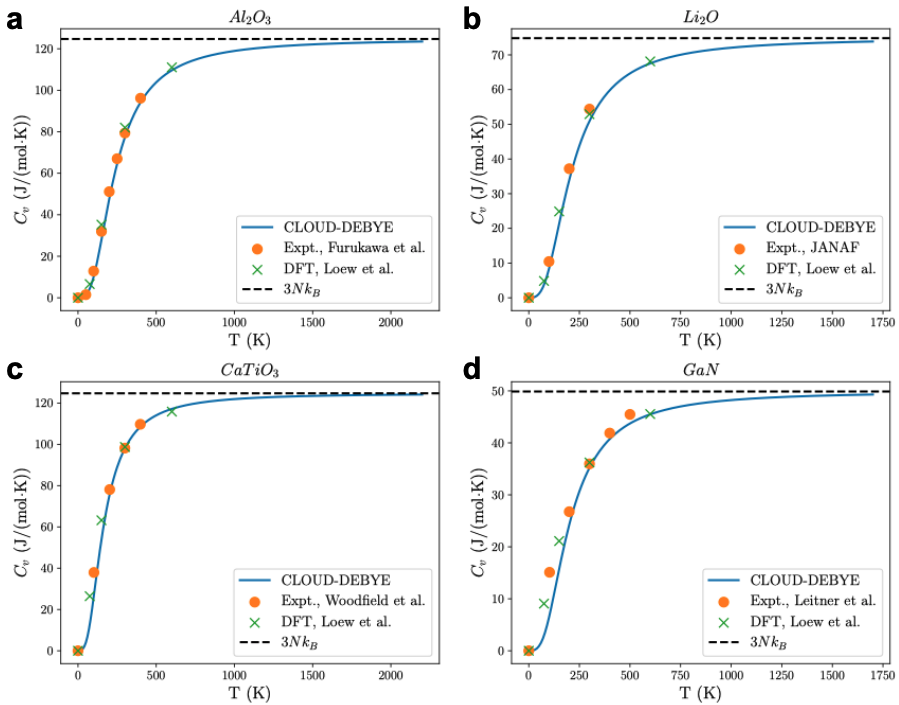

In the meantime, you can see that even if we don't train a good enough model in this demo, the model predictions for $C_v$ under different temepratures are still physics-consistent, even though not accurate. This highlights the significance of using physics to guide/constrain the ML models.